# BDA project "Pump It Up"

- Анастасия Барковая
- Варвара Михайлова
- Анна Снигирева

# 1. Проблема

В соответствии с [water.org ](https://water.org ), 4 миллиона человек в Танзании не имеют доступа к улучшенному источнику безопасной воды.

Люди, живущие в таких условиях, тратят значительное количество времени на поездки на большие расстояния, чтобы набрать воды в пунктах сбора воды.

Точное предсказание того, функционируют насосы или нет, действительно важно, поскольку люди подвергаются риску ухудшения здоровья или даже смерти от обезвоживания.

![image.png](attachments/image.png)

Используя данные Taarifa и Министерства водного хозяйства Танзании, мы должны понимать, какие насосы исправны, какие нуждаются в некотором ремонте, а какие вообще не работают. Прогноз будет основан на ряде переменных, касающихся того, какой тип насоса работает, когда он был установлен и как им управляют. Четкое понимание того, какие пункты водоснабжения выйдут из строя, может улучшить операции по техническому обслуживанию и обеспечить доступность чистой питьевой воды для населения по всей Танзании.

[Ссылка на конкурс](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table )

# 2. Подгрузка датасета

In [166]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
try:
    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
except:
    !pip install cartopy
    import cartopy.feature as cfeature
    import cartopy.crs as ccrs

In [2]:
X = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv", index_col=0)
y = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv", index_col=0)
assert (X.index == y.index).all()

In [3]:
pd.options.display.max_columns = 41
X.head(5)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Посмотрим, сколько всего количественных и категориальных признаков

In [4]:
cat_features = 0
numeric_features = 0
for column, tp in X.dtypes.items():
    if str(tp) == 'object':
        cat_features += 1
    else:
        numeric_features += 1
print(f'There are {cat_features} categorial features and {numeric_features} numeric features.')

There are 30 categorial features and 9 numeric features.


Посмотрим, сколько N/A признаков

In [5]:
y.isna().sum()

status_group    0
dtype: int64

In [6]:
categorial_nan_count = X.select_dtypes(include=['object']).isna().sum()
numeric_nan_count = X.select_dtypes(exclude=['object']).isna().sum()
print(f'NaN in Categorial:\n{(categorial_nan_count != 0).sum()}')
print(f'NaN in Numerics:\n{(numeric_nan_count != 0).sum()}')


NaN in Categorial:
7
NaN in Numerics:
0


Как видим, NaN встречается только в категориальных признаках, поэтому заменим строкой "None"

In [7]:
X.fillna(value="None", inplace=True)

Составим общую таблицу, соединив X и y

In [45]:
df = pd.merge(X, y, on='id', how='inner')
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,None,GeoData Consultants Ltd,Other,None,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,None,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,None,None,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Посмотрим, какое распределение насосов каждого типа по глубине

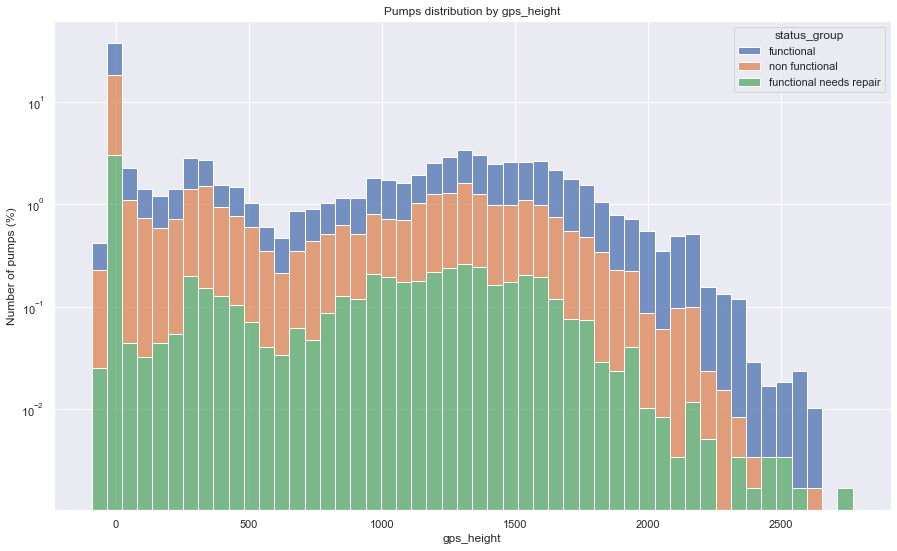

In [222]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.histplot(data=df, x="gps_height", hue="status_group", stat='percent', bins=50, multiple="stack");
plt.yscale('log')
plt.ylabel('Number of pumps (%)');
plt.title('Pumps distribution by gps_height');
plt.show()

### Посмотрим расположение точек на карте

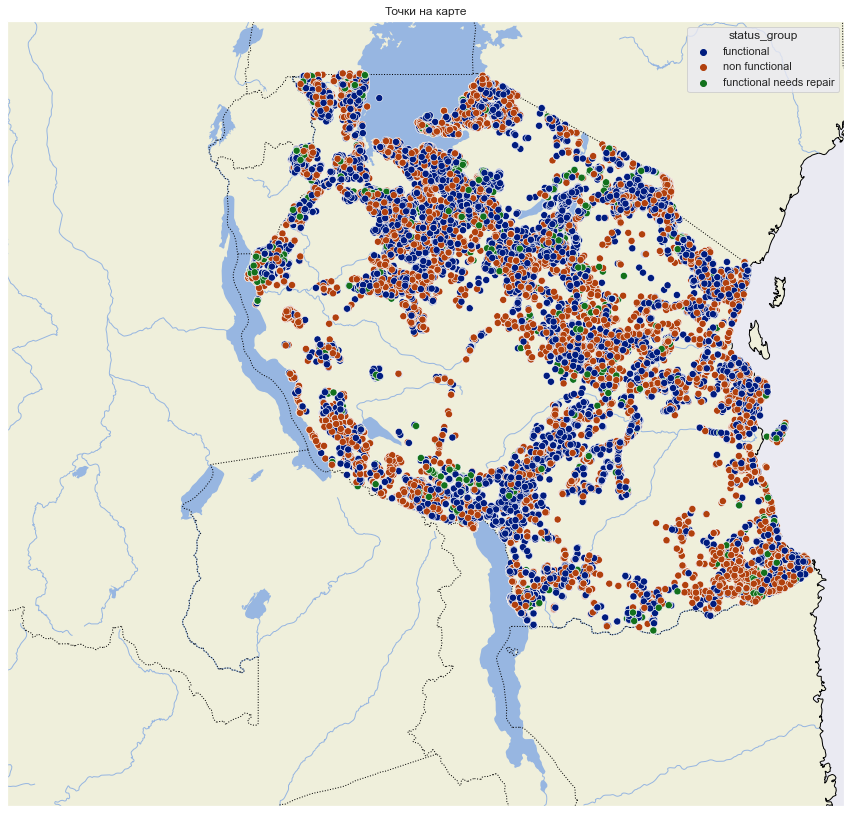

In [221]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 15))
min_lon = 25  # Минимальная долгота
max_lon = 41  # Максимальная долгота
min_lat = -15  # Минимальная широта
max_lat = 0   # Максимальная широта
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

sns.scatterplot(data = df, x = "longitude", y = "latitude", hue='status_group', marker='o',
                s=50, transform=ccrs.PlateCarree(), zorder=3, palette = "dark")
ax.set_title('Точки на карте')

plt.show()

### Рассмотрим cуммарное количество воды по географическим локациям:

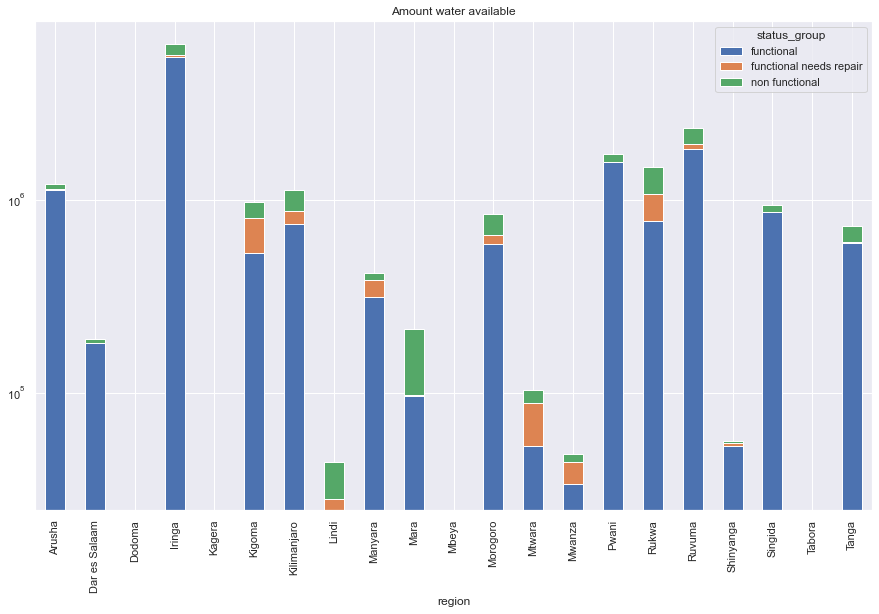

In [220]:
fig, ax = plt.subplots(figsize=(15, 9))


_data = df.groupby(["region", "status_group"])['amount_tsh'].sum().unstack()
_data.plot(kind='bar', stacked=True, ax=ax);
plt.yscale('log')
#plt.ylabel('Number of pumps (%)');
plt.title('Amount water available');
plt.show()

### Видно, что от местности к местности, значения меняются. Поэтому рассмотрим количество воды в насосах на душу населения рядом с насосом в зависимости от региона

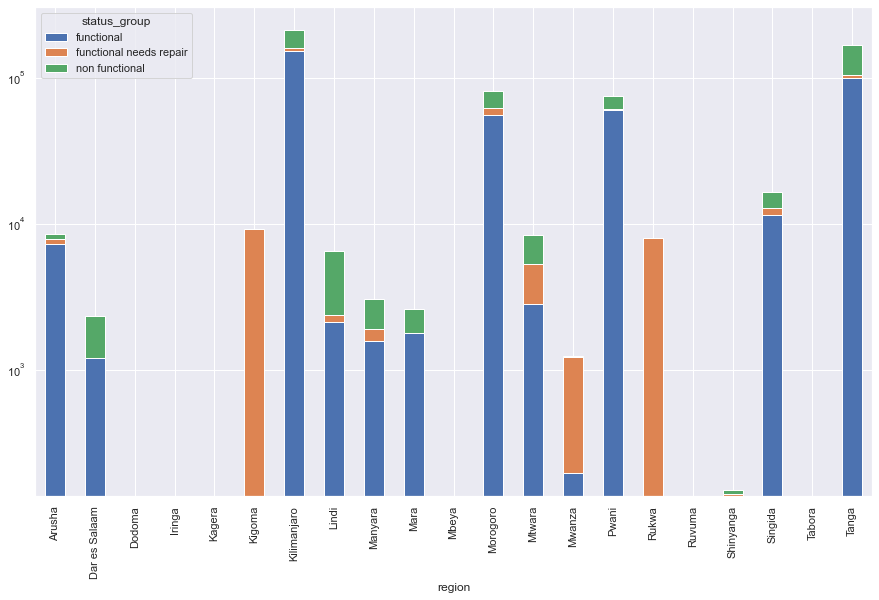

In [224]:
fig, ax = plt.subplots(figsize=(15, 9))

df['amount_per_one'] = df['amount_tsh']/df['population']
_data = df.groupby(["region", "status_group"])
_data = _data.amount_per_one.sum().unstack()
_data.plot(kind='bar', stacked=True, ax=ax);
plt.yscale('log')
plt.show()